<a id='intro'></a>
<div class="alert alert-block alert-warning"> 
<h1 align="center">Introduction</h3>

### Table of Contents
1. [Introduction](#intro)
2. [Data Wrangling](#wrangling)
  * [General Properties](#properties)
  * [Data Cleaning](#cleaning)
3. [Exploratory Data Analysis](#eda)
  * [Which months are the best times to view movies?](#months)
  * [Which actors, directors, and production companies produce the best movies by genre?](#top_10)
4. [Modeling](#modeling)
  * [Preprocessing](#preprocessing)
  * [Fitting the Linear Regression Model](#fit_lin)
5. [Explore Possible Improvements](#improvements)
  * [Increase the number of actors, directors, and production companies used](#top500)
  * [Preprocessing Changes](#new_preprocessing)
6. [New Models](#new_models)
  * [Model 2](#model2)
  * [Model 3](#model3)
  * [Model 4](#model4)
  * [Model 5](#model5)
7. [Classification](#classification)
  * [Fitting the Classifier](#fit_clf)
  * [CLF](#clf)

For this project, I would like to predict the average rating of a movie before it has been released by building a machine learning model. The target audience for this project is the movie industry iteself. The goal here is to determine what combination of cast, director, production company, and budget will be suitable to produce a highly rated movie. In doing so, scriptwriters can choose the right cast, director, and production company to produce their movie; executives of a production company can choose the right cast and director given a specific budget; and a director can choose which actors to cast.

Using this notebook, I will detail each of the steps I take towards achieving this goal. I will begin by performing [Data Wrangling](#wrangling), in which I will take a look at the data and see how I should properly clean and transform the data in order to proceed. Then, I will perform [Exploratory Data Analysis](#eda) to explore possible features to include in my model. I will then proceed to the [Modeling](#modeling) phase where I will build and test an initial linear regression model. It is expected that the first model will have many issues, thus I will move onto the next phase where I will [Explore Possible Improvements](#improvements). Once a few ideas have been established, I will incorporate them by building several [New Models](#new_models) and comparing their performances. The last phase of my project will involve [Classification](#classification), in which I will find and convert models I believe will perform better as a classification model instead of a linear regression model.

By the end of the notebook, I will have built a finalized model capable of predicting a movie's average rating to a certain degree of accuracy.

<a id='wrangling'></a>
<div class="alert alert-block alert-warning">
<h1 align="center">Data Wrangling</h3>

<a id='properties'></a>
### General Properties
#### Description:
> Datasets are often riddled with various issues upon the first import, so I must examine the data and make necessary changes so my analysis can proceed as smooth as possible.

#### Procedure:
> Import the dataset and take a look at the data , and determine if necessary changes will be needed.
1. Make preliminary observations
  1. Import dataset and look at the first 3 entries
  2. Explore anything that stands out
2. Check for inconsistencies in data types, such as numerical values and dates being incorrectly represented as strings
4. Take a look at the columns and see which ones will be most important for my analysis

In [259]:
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.svm import SVC

In [260]:
# Import dataset and look at the first 3 entries
df = pd.read_csv('tmdb-movies.csv')
df.head(3)

,id,imdb_id,popularity,budget,revenue,original_title,cast,homepage,director,tagline,...,overview,runtime,genres,production_companies,release_date,vote_count,vote_average,release_year,budget_adj,revenue_adj
0,135397,tt0369610,32.985763,150000000,1513528810,Jurassic World,Chris Pratt|Bryce Dallas Howard|Irrfan Khan|Vi...,http://www.jurassicworld.com/,Colin Trevorrow,The park is open.,...,Twenty-two years after the events of Jurassic ...,124,Action|Adventure|Science Fiction|Thriller,Universal Studios|Amblin Entertainment|Legenda...,6/9/15,5562,6.5,2015,1.379999e+08,1.392446e+09
1,76341,tt1392190,28.419936,150000000,378436354,Mad Max: Fury Road,Tom Hardy|Charlize Theron|Hugh Keays-Byrne|Nic...,http://www.madmaxmovie.com/,George Miller,What a Lovely Day.,...,An apocalyptic story set in the furthest reach...,120,Action|Adventure|Science Fiction|Thriller,Village Roadshow Pictures|Kennedy Miller Produ...,5/13/15,6185,7.1,2015,1.379999e+08,3.481613e+08
2,262500,tt2908446,13.112507,110000000,295238201,Insurgent,Shailene Woodley|Theo James|Kate Winslet|Ansel...,http://www.thedivergentseries.movie/#insurgent,Robert Schwentke,One Choice Can Destroy You,...,Beatrice Prior must confront her inner demons ...,119,Adventure|Science Fiction|Thriller,Summit Entertainment|Mandeville Films|Red Wago...,3/18/15,2480,6.3,2015,1.012000e+08,2.716190e+08


In [261]:
# Check for multiple values
for x in df.columns:
    if type(df[x][0]) == str:
        if df[x].str.contains("\|").any():
            print(x)

cast
director
tagline
keywords
overview
genres
production_companies


> It seems that the __'cast'__, __'director'__, __'tagline'__, __'keywords'__, __'overview'__, __'genres'__, __'production_companies'__ columns have multiple values per entry.
<br> I will have to keep this in mind and find a way to expand each entry for future analysis.

In [262]:
# Check for inconsistencies in data types
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10866 entries, 0 to 10865
Data columns (total 21 columns):
id                      10866 non-null int64
imdb_id                 10856 non-null object
popularity              10866 non-null float64
budget                  10866 non-null int64
revenue                 10866 non-null int64
original_title          10866 non-null object
cast                    10790 non-null object
homepage                2936 non-null object
director                10822 non-null object
tagline                 8042 non-null object
keywords                9373 non-null object
overview                10862 non-null object
runtime                 10866 non-null int64
genres                  10843 non-null object
production_companies    9836 non-null object
release_date            10866 non-null object
vote_count              10866 non-null int64
vote_average            10866 non-null float64
release_year            10866 non-null int64
budget_adj              1

> The **release_date** column is of data type `str`, and will need to be parsed into a `datetime` object.

In [263]:
# Take a look at all columns
list(df.columns)

['id',
 'imdb_id',
 'popularity',
 'budget',
 'revenue',
 'original_title',
 'cast',
 'homepage',
 'director',
 'tagline',
 'keywords',
 'overview',
 'runtime',
 'genres',
 'production_companies',
 'release_date',
 'vote_count',
 'vote_average',
 'release_year',
 'budget_adj',
 'revenue_adj']

> The dataset includes many columns, but the only columns I am interested in for my analysis are the following:
* [__original_title__, __cast__, __director__, __genres__, __production_companies__, __release_date__, __vote_average__, __release_year__, __budget_adj__, __revenue_adj__]

<a id='cleaning'></a>
### Data Cleaning
#### Description:
> To clean the data, there are two main tasks I must complete: parsing the release_date column into `datetime` objects, and dropping several columns and rows.
<br> Firstly, I must parse the release_date column into `datetime` objects in order for python to recognize the values as dates. <br> Secondly, I must drop all columns that are unnecessary for my analysis; I must drop all rows containing null values; and I must drop all rows containing zeros, specifically for columns containing numerical values (__vote_average__, __budget__, __revenue__).

#### Convert the 'release_date' column to datetime
> Parsing the column using the typical parse_dates argument of pd.read_csv or the pd.to_datetime function does not work properly. The reason being that the column contains years in the 1900s, and Python assumes all years are in the 21st century, resulting in incorrectly parsed future years. I will have to correctly identify and fix the problematic years before parsing the column.
* Create a boolean mask to locate problematic years
* Correctly label the dates
* Parse the column to datetime

#### Columns and rows to drop
> I will drop the __budget__ and __revenue__ columns and use their adjusted values instead

> I will drop all columns except for the following, which I will be using for my analysis:
* [__original_title__, __cast__, __director__, __genres__, __production_companies__, __release_date__, __vote_average__, __release_year__, __budget__, __revenue__]

> I will drop all null values

> I will drop rows with zeros in relevant columns I will be analysing
* __vote_average__, __budget__, __revenue__



In [264]:
# Python does not properly parse certain years (ex: 1-1-66 gets parsed as 2066-1-1)
# Include a '19' in front of all years in the 1900's to clearly indicate the century
from datetime import datetime

df = pd.read_csv('tmdb-movies.csv')

# Boolean mask for years in the 1900's
incorrect_dates = df['release_year'] < 2000
# Correct the dates
df.loc[incorrect_dates,'release_date'] = df[incorrect_dates]['release_date'].apply(lambda x: x[:-2] + '19' + x[-2:])
# Parse release_date column
df['release_date'] = pd.to_datetime(df['release_date'])

In [265]:
# Drop budget and revenue columns
df.drop(columns=['budget','revenue'], inplace=True)
# Rename budget_adj column to budget
df.rename(columns={'budget_adj':'budget','revenue_adj':'revenue'}, inplace=True)

# List of columns to keep ['original_title','cast','director','genres','production_companies','release_date','vote_average','release_year','budget']
keep_list = ['original_title','cast','director','genres','production_companies','release_date','vote_average','budget','revenue']
# Update DataFrame
df = df[keep_list]

# Change all values of 'nan' to null values, then drop rows with null values
df.dropna(subset=['original_title','cast','director','genres','production_companies','release_date'], inplace=True)

# Drop rows with zeros in relevant columns
df = df.loc[df[['vote_average','budget','revenue']].ne(0).all(axis=1)]

df.head()

,original_title,cast,director,genres,production_companies,release_date,vote_average,budget,revenue
0,Jurassic World,Chris Pratt|Bryce Dallas Howard|Irrfan Khan|Vi...,Colin Trevorrow,Action|Adventure|Science Fiction|Thriller,Universal Studios|Amblin Entertainment|Legenda...,2015-06-09,6.5,1.379999e+08,1.392446e+09
1,Mad Max: Fury Road,Tom Hardy|Charlize Theron|Hugh Keays-Byrne|Nic...,George Miller,Action|Adventure|Science Fiction|Thriller,Village Roadshow Pictures|Kennedy Miller Produ...,2015-05-13,7.1,1.379999e+08,3.481613e+08
2,Insurgent,Shailene Woodley|Theo James|Kate Winslet|Ansel...,Robert Schwentke,Adventure|Science Fiction|Thriller,Summit Entertainment|Mandeville Films|Red Wago...,2015-03-18,6.3,1.012000e+08,2.716190e+08
3,Star Wars: The Force Awakens,Harrison Ford|Mark Hamill|Carrie Fisher|Adam D...,J.J. Abrams,Action|Adventure|Science Fiction|Fantasy,Lucasfilm|Truenorth Productions|Bad Robot,2015-12-15,7.5,1.839999e+08,1.902723e+09
4,Furious 7,Vin Diesel|Paul Walker|Jason Statham|Michelle ...,James Wan,Action|Crime|Thriller,Universal Pictures|Original Film|Media Rights ...,2015-04-01,7.3,1.747999e+08,1.385749e+09


<a id='eda'></a>
<div class="alert alert-block alert-warning">
<h1 align="center">Exploratory Data Analysis</h3>

<a id='months'></a>
### Which months are the best times to view movies?
#### Description:
> Determine which months have the highest average rating, view the median number of movies released each month, and determine the average budget for movies by their release month.

#### Procedure:
> 
1. Plot the average rating vs. release month
  1. Create a copy of the DataFrame and name it __rating_by_month__
  2. Convert the __release_date__ column to numerical representations of the month
  3. Group by __release_date__, then find the mean of the __vote_average__, and plot the values
2. Plot the median number of movies each month
  1. Create a copy of the DataFrame with the index set to __release_date__ and name it __monthly_count__
  2. Resample the __monthly_count__ DataFrame by month, and count the number of movies that appear each month
  3. Drop the months with zero movies
  4. Reset the index
  5. Convert the __release_date__ column to numerical representations of the month
  6. Group by __release_date__, then find the median number of movies for each month, and plot as a bar chart
3. Plot the average budget vs. release_month
  1. Create a copy of the DataFrame and name it __budget_info__
  2. Convert the __release_date__ column to numerical representations of the month
  3. Group by __release_date__, then find the mean of the __budget__, and plot the values

##### 1. Plot the average rating vs. release month
##### 2. Plot the median number of movies each month
##### 3. Plot the average budget vs. release_month

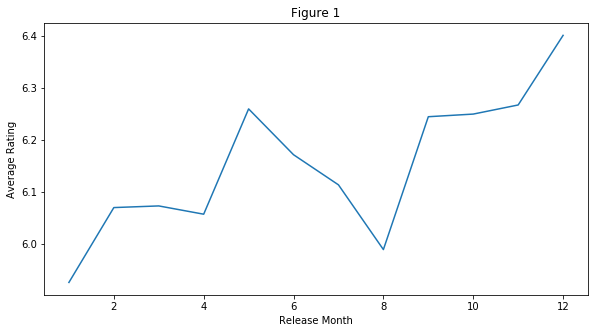

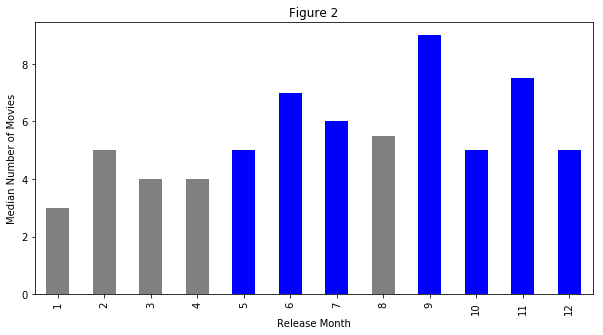

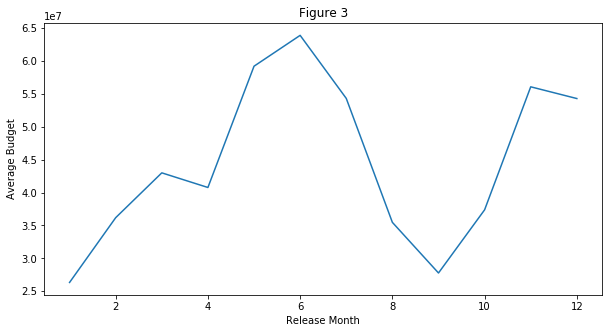

In [266]:
# Plot the average rating vs. release month
plt.figure
rating_by_month = df.copy()
rating_by_month['release_date'] = rating_by_month['release_date'].dt.month
rating_by_month.groupby('release_date')['vote_average'].mean().plot(figsize=(10,5))
plt.subplots_adjust(left = 0.145)
plt.title('Figure 1')
plt.xlabel('Release Month')
plt.ylabel('Average Rating')
plt.show()

# Plot the median number of movies each month
plt.figure
monthly_count = df.set_index('release_date')
monthly_count = monthly_count.resample('M').count()
monthly_count = monthly_count.loc[monthly_count.ne(0).all(axis=1)]
monthly_count = monthly_count.reset_index()
monthly_count['release_date'] = monthly_count['release_date'].dt.month
standout = ['grey','grey','gray','grey','b','b','b','grey','b','b','b','b']
monthly_count.groupby('release_date')['original_title'].median().plot(kind='bar', color=standout, figsize=(10,5))
plt.title('Figure 2')
plt.xlabel('Release Month')
plt.ylabel('Median Number of Movies')
plt.show()

# Plot the average budget vs. release_month
plt.figure
budget_info = df.copy()
budget_info['release_date'] = budget_info['release_date'].dt.month
budget_info.groupby('release_date')['budget'].mean().plot(figsize=(10,5))
plt.title('Figure 3')
plt.xlabel('Release Month')
plt.ylabel('Average Budget');

> By comparing Figures 1 and 2, it is quite clear that movies released on certain months have a higher average rating than others. This seems to be correlated with the observation that months with higher average ratings also have a higher number of newly released movies. These observations lead to a possible correlation between a movie's rating and the month it was released.

> By comparing Figures 1 and 3, an odd observation is discovered. The average ratings and the average budget for the months of May, June, July, November, and December seem to be correlated; but this is not true for the months of September, and October. Although the latter is observed, it seems that there may still be a correlation between a movie's budget and its rating.

<a id='top_10'></a>
### Which actors, directors, and production companies produce the best movies by genre?
#### Description:
> I would like to find the top 10 actors/directors/production_companies by genre in order to use these values in the modeling phase to build my features. This will allow my model to predict a movie's ratings by learning who the best actors, directors, and production companies are.

#### Procedure:
> I will have to first write a function to expand each of these columns. Once the columns are expanded, I will be able to group the data by the genres and the features, then find the 10 values with the highest rating.
1. Preliminary steps:
  1. Write a function to expand each of these columns, as each row contains multiple values
  2. Expand the columns
2. Find the top 10 actors by genre
  1. Group by the __genres__ and __cast__ column, then find the mean of the __vote_average__ column
  2. Take the previous groupby object, groupby the __genres__ colum, then find the top 10 values from the __vote_average__ column
3. Find the top 10 directors by genre
  1. Group by the __genres__ and __director__ column, then find the mean of the __vote_average__ column
  2. Take the previous groupby object, groupby the __genres__ colum, then find the top 10 values from the __vote_average__ 
4. Find the top 10 production companies by genre
  1. Group by the __genres__ and __production_companies__ column, then find the mean of the __vote_average__ column
  2. Take the previous groupby object, groupby the __genres__ colum, then find the top 10 values from the __vote_average__ 

##### 1. Preliminary steps:

In [267]:
# Function to expand columns with multiple values
def expand(df_in, column, sep='|'):
    """
    !!! IMPORTANT !!! : 
        df_in MUST HAVE NO NULL VALUES
    !!! IMPORTANT !!!
    
    Split the values of a column and expand so the new
    DataFrame has one row per value.
    """
    indexes = list()
    new_values = list()
    # Find all rows, and column values to expand
    for i, presplit in enumerate(df_in[column]):
        # Expand the column values and store
        values = presplit.split(sep)
        new_values += values
        # Duplicate the row index and store
        indexes += [i] * len(values)
    # Copy of the original DataFrame with duplicate
     # rows to match expanded column
    df_out = df_in.iloc[indexes, :].copy()
    # Replace the column with the expanded values
    df_out[column] = new_values
    # Renumber the index
    df_out.index = list(range(len(df_out)))
    
    return df_out

In [268]:
# Test to see it can properly expand the columns

# Columns to expand
expand_columns = ['cast','director', 'genres','production_companies']

# Create a new dataframe
test = df.copy()
# Loop through all columns
count = 0
for column in expand_columns:
    test = expand(test,column)
    if not test[column].str.contains("\|").any():
        count += 1
    # Check to see it worked
    # Should print, "Properly expanded!"
    if count == 4:
        print('Properly expanded!')

Properly expanded!


In [269]:
# Expand the genres column, and store in a new DataFrame
expand_genres = expand(df.copy(), 'genres')

# Create a list of all the genres
genres_list = sorted(list(expand_genres['genres'].unique()))

# Create a new DataFrame for each attribute and expand the corresponding column
cast_genres = expand(expand_genres, 'cast')
dir_genres = expand(expand_genres, 'director')
prod_genres = expand(expand_genres, 'production_companies')

##### 2. Find the top 100 actors by genre

In [270]:
# Find the top 10 actors by genre
cast_averages = pd.DataFrame(cast_genres.groupby(['genres', 'cast'])['vote_average'].mean())
find_top_10 = cast_averages['vote_average'].groupby(level=0, group_keys=False)
top_10_cast = pd.DataFrame(find_top_10.nlargest(10)).reset_index()
top_10_cast = top_10_cast.groupby('genres')['cast'].unique().to_dict()

##### 3. Find the top 10 directors by genre

In [271]:
# Find the top 10 directors by genre
dir_averages = pd.DataFrame(dir_genres.groupby(['genres', 'director'])['vote_average'].mean())
find_top_10 = dir_averages['vote_average'].groupby(level=0, group_keys=False)
top_10_dir = pd.DataFrame(find_top_10.nlargest(10)).reset_index()
top_10_dir = top_10_dir.groupby('genres')['director'].unique().to_dict()

##### 4. Find the top 10 production companies by genre

In [272]:
# Find the top 10 production companies by genre
prod_averages = pd.DataFrame(prod_genres.groupby(['genres', 'production_companies'])['vote_average'].mean())
find_top_10 = prod_averages['vote_average'].groupby(level=0, group_keys=False)
top_10_prod = pd.DataFrame(find_top_10.nlargest(10)).reset_index()
top_10_prod = top_10_prod.groupby('genres')['production_companies'].unique().to_dict()

<a id='modeling'></a>
<div class="alert alert-block alert-warning">
<h1 align="center">Modeling</h3>

<a id='preprocessing'></a>
### Preprocessing
#### Description:
> I must run my data through a preprocessing procedure in order to build the feature columns that my model will learn from. 

> First, I must build the feature columns for the **cast**, **director**, and **production_companies__** by counting the number of times each movie has a feature that appears at least once in the top 10 lists for its corresponding genres.
<br> To explain this, lets use a movie categorized under the genres of Action and Adventure as an example. I will then count the number of times the following are true: the movie has at least one actor from the top 10 action list, at least one actor from the top 10 adventure list, at least one director from the top 10 action list, etc.

> Next, I will build the feature columns for the **genres** by creating one column for each genre. Each column/genre will have a value of a 0 if the movie is not categorized under this genre, and a 1 if the movie is categorized under this genre.

> Lastly, I will build a feature column representing the month that each movie was released, by converting the **release_date** column into numerical representations of month.

#### Procedure:
> Build the feature columns for the **cast**, **director**, **production_companies**, **genres**, and **release_date** in order to fit the data to a linear regression model.
1. Build the cast, director, and production_companies feature columns
  1. Loop through the features and their corresponding DataFrames
    1. Split the feature column into a list using the .split() method
  2. Loop through the genres
    1. Find all movies in correspondence with the top 10 of the current feature for the current genre
2. Build the genre feature columns
  1. Use pd.get_dummies() to create dummy variables
  2. Drop the original genres column
3. Collapse the DataFrame back to one movie per row
  1. Collapse genre features
    1. Groupby **original_title** and **release_date**, then sum the genre columns
  2. Collapse remaining features
    2. Groupby **original_title** and **release_date**, then find the unique values for the remaining columns
4. Build the release_date feature column
  1. Use the dt.month method to convert the column into integer values of month
5. Combine all steps into one function

##### 1. Build the cast, director, and production_companies feature columns

In [273]:
# List of features
features = ['cast', 'director', 'production_companies']
# List of dataframes
dataframes = [top_10_cast, top_10_dir, top_10_prod]
# Copy the expand_genres DataFrame
model_df = expand_genres[expand_genres.columns]

# Loop through the features and their corresponding DataFrames
for i in range(3):
    feature = features[i]
    data =  dataframes[i]
    # Split the feature column
    model_df[feature] = model_df[feature].apply(lambda x: x.split('|'))
    
    # Loop through the genres
    for genre in genres_list:
        # Top 10 of the current feature for the current genre
        top_10 = data[genre]

        # Find all movies with a top_10 feature for the current genre
        temp = model_df.loc[model_df.genres == genre, feature].apply(lambda values: any(hit in values for hit in top_10)).astype(int)
        
        # Update the dataframe
        model_df.loc[model_df.genres == genre, feature] = temp

# Check the DataFrame to confirm changes
model_df.head(3)

,original_title,cast,director,genres,production_companies,release_date,vote_average,budget,revenue
0,Jurassic World,0,0,Action,0,2015-06-09,6.5,1.379999e+08,1.392446e+09
1,Jurassic World,0,0,Adventure,0,2015-06-09,6.5,1.379999e+08,1.392446e+09
2,Jurassic World,0,0,Science Fiction,0,2015-06-09,6.5,1.379999e+08,1.392446e+09


##### 2. Build the genre feature columns

In [274]:
# Create dummy variables
model_df[genres_list] = pd.get_dummies(model_df['genres'])
# Drop the original 'genres' column
model_df.drop(columns='genres', inplace=True)

# Check the DataFrame to confirm changes
model_df.head(3)

,original_title,cast,director,production_companies,release_date,vote_average,budget,revenue,Action,Adventure,...,History,Horror,Music,Mystery,Romance,Science Fiction,TV Movie,Thriller,War,Western
0,Jurassic World,0,0,0,2015-06-09,6.5,1.379999e+08,1.392446e+09,1,0,...,0,0,0,0,0,0,0,0,0,0
1,Jurassic World,0,0,0,2015-06-09,6.5,1.379999e+08,1.392446e+09,0,1,...,0,0,0,0,0,0,0,0,0,0
2,Jurassic World,0,0,0,2015-06-09,6.5,1.379999e+08,1.392446e+09,0,0,...,0,0,0,0,0,1,0,0,0,0


##### 3. Collapse the DataFrame back to one movie per row

In [275]:
# Collapse the genre features back to one movie per row
genre_features = model_df.groupby(['original_title', 'release_date'])[genres_list].sum().reset_index()

# Collapse the remaining features back to one movie per row
agg_dict = {'cast':'sum', 'director':'sum', 'production_companies':'sum', 'vote_average':'mean', 'budget':'mean'}
remaining_features = model_df.groupby(['original_title', 'release_date']).agg(agg_dict)

# Join the features
model_df = genre_features.join(remaining_features, on=['original_title', 'release_date'])

# Check the DataFrame to confirm changes
model_df.head(10)

,original_title,release_date,Action,Adventure,Animation,Comedy,Crime,Documentary,Drama,Family,...,Science Fiction,TV Movie,Thriller,War,Western,cast,director,production_companies,vote_average,budget
0,(500) Days of Summer,2009-07-17,0,0,0,1,0,0,1,0,...,0,0,0,0,0,0,0,0,7.3,7.623003e+06
1,10 Things I Hate About You,1999-03-30,0,0,0,1,0,0,1,0,...,0,0,0,0,0,0,0,0,7.2,2.094485e+07
2,"10,000 BC",2008-02-22,1,1,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,5.2,1.063426e+08
3,101 Dalmatians,1996-11-17,0,0,0,1,0,0,0,1,...,0,0,0,0,0,0,0,0,5.5,7.507170e+07
4,102 Dalmatians,2000-10-07,0,0,0,1,0,0,0,1,...,0,0,0,0,0,0,0,0,5.0,1.076348e+08
5,10th & Wolf,2006-02-19,1,0,0,0,1,0,1,0,...,0,0,1,0,0,0,0,0,6.0,8.653353e+06
6,12 Rounds,2009-03-19,1,1,0,0,0,0,1,0,...,0,0,1,0,0,0,0,0,5.9,2.032801e+07
7,12 Years a Slave,2013-10-18,0,0,0,0,0,0,1,0,...,0,0,0,0,0,1,1,1,7.9,1.872067e+07
8,127 Hours,2010-11-05,0,1,0,0,0,0,1,0,...,0,0,1,0,0,0,0,0,6.9,1.800000e+07
9,13 Going On 30,2004-04-13,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,6.1,4.271448e+07


##### 4. Build the release_date feature column

In [276]:
# Convert release dates to month
model_df['release_date'] = model_df['release_date'].dt.month

# Check the DataFrame to confirm changes
model_df.head(3)

,original_title,release_date,Action,Adventure,Animation,Comedy,Crime,Documentary,Drama,Family,...,Science Fiction,TV Movie,Thriller,War,Western,cast,director,production_companies,vote_average,budget
0,(500) Days of Summer,7,0,0,0,1,0,0,1,0,...,0,0,0,0,0,0,0,0,7.3,7.623003e+06
1,10 Things I Hate About You,3,0,0,0,1,0,0,1,0,...,0,0,0,0,0,0,0,0,7.2,2.094485e+07
2,"10,000 BC",2,1,1,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,5.2,1.063426e+08


##### 5. Combine all steps into one function

In [277]:
def preprocessing(top_cast, top_dir, top_prod, model_df):
    '''1. Build the cast, director, and production_companies feature columns'''
    # List of features
    features = ['cast', 'director', 'production_companies']
    # List of dataframes
    dataframes = [top_cast, top_dir, top_prod]

    # Loop through the features and their corresponding DataFrames
    for i in range(3):
        feature = features[i]
        data =  dataframes[i]
        # Split the feature column
        model_df[feature] = model_df[feature].apply(lambda x: x.split('|'))
        
        # Loop through the genres
        for genre in genres_list:
            try:
                # Top n of the current feature for the current genre
                top_n = data[genre]

                # Find all movies with a top_n feature for the current genre
                temp = model_df.loc[model_df.genres == genre, feature].apply(lambda values: any(hit in values for hit in top_n)).astype(int)

                # Update the dataframe
                model_df.loc[model_df.genres == genre, feature] = temp
            except:
                model_df.loc[model_df.genres == genre, feature] = 0
    
    '''2. Build the genre feature columns'''
    # Create dummy variables for genres
    model_df[genres_list] = pd.get_dummies(model_df['genres'])
    # Drop the original 'genres' column
    model_df.drop(columns='genres', inplace=True)
    
    '''3. Collapse the DataFrame back to one movie per row'''
    # Collapse the genre features back to one movie per row
    genre_features = model_df.groupby(['original_title', 'release_date'])[genres_list].sum().reset_index()
    
    # Collapse the remaining features back to one movie per row
    agg_dict = {'cast':'sum', 'director':'sum', 'production_companies':'sum', 'vote_average':'mean', 'budget':'mean'}
    remaining_features = model_df.groupby(['original_title', 'release_date']).agg(agg_dict)

    # Join the features
    model_df = genre_features.join(remaining_features, on=['original_title', 'release_date'])
    
    '''4. Build the release_date feature column'''
    # Convert release dates to month
    model_df['release_date'] = model_df['release_date'].dt.month
    
    return model_df

<a id='fit_lin'></a>
### Fitting the Linear Regression Model
#### Description:
> Fit the data to a linear regression model using OLS (Ordinary Least Squares)

#### Procedure:
> Using the **cast**, **director**, **production_companies**, **release_date**, **budget**, and the **genres** columns as the features and the **vote_average** column as the target, split the data into training and test sets. Fit the model to the training set, and use the fitted model to predict the average rating.
1. Split the data into training and test sets
  1. Split the DataFrame into two variables, X for the features, and y for the target
  2. Use the train_test_split function to split the data into a training set, and a test set
  3. Standardize the features of the training and test sets
2. Fit the model to the training set using the LinearRegression class from sklearn.linear_model
3. Plot the ratings vs their predictions
4. Combine all steps into one function

##### 1. Split the data into training and test sets

In [278]:
# Variable to hold feature data
X = model_df.drop(columns=['original_title', 'vote_average'])

# Variable to hold target data
y = model_df['vote_average']

# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

# Standardize the features
temp = StandardScaler().fit(X_train)
X_train = temp.transform(X_train)
X_test = temp.transform(X_test)

##### 2. Fit the model to the training set

In [279]:
model = LinearRegression()
results = model.fit(X_train, y_train)

<a id='results1'></a>
##### 3. Evaluate model performance

R^2 (Training): 0.2552991953573587
R^2 (Test): 0.21130813333466592
MSE: 0.4738747447476443


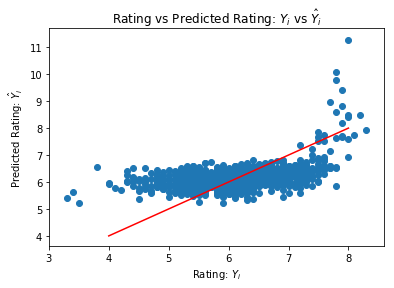

In [280]:
# Results using sklearn
y_pred = results.predict(X_test)

# Print the R^2 score
print('R^2 (Training): {}'.format(results.score(X_train, y_train)))
print('R^2 (Test): {}'.format(results.score(X_test, y_test)))

# Print the mean squared error
print('MSE: {}'.format(mean_squared_error(y_test, y_pred)))

# Plot the Rating vs. Predicted Rating
plt.plot([4,8],[4,8], color='red')
plt.scatter(y_test, y_pred)
plt.xlabel("Rating: $Y_i$")
plt.ylabel("Predicted Rating: $\hat{Y}_i$")
plt.title("Rating vs Predicted Rating: $Y_i$ vs $\hat{Y}_i$");

##### Top 10 metric results
> As you can see from the plot above, this model does a poor job of predicting the ratings.
<br> I think the main reason for its poor performance is the scarcity of the **cast**, **director**, and **production_companies** feature columns.

> I will now explore some ideas to alter those feature columns in order to improve the model.
<div class="alert alert-block alert-success">
Comparisons:
* [top 500 metric](#results2)
* [new preprocessing](#results3)
* [model 2 (old preprocessing)](#results5)

##### 4. Combine all steps into one function

In [281]:
def fit_model(model_df):
    '''1. Split the data into training and test sets'''
    # Variable to hold feature data
    X = model_df.drop(columns=['original_title', 'vote_average'])
    
    # Variable to hold target data
    y = model_df['vote_average']
    
    # Split the data into training and test sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)
    
    # Standardize the features
    temp = StandardScaler().fit(X_train)
    X_train = temp.transform(X_train)
    X_test = temp.transform(X_test)

    '''2. Fit the model to the training set'''
    model = LinearRegression()
    results = model.fit(X_train, y_train)

    '''3. Evaluate model performance'''
    # Results using sklearn
    y_pred = results.predict(X_test)
    
    # Print the R^2 score
    print('R\u00b2 (Training): {}'.format(results.score(X_train, y_train)))
    print('R\u00b2 (Test): {}'.format(results.score(X_test, y_test)))
    
    # Print the mean squared error
    print('MSE: {}'.format(mean_squared_error(y_test, y_pred)))
    
    # Plot the Rating vs. Predicted Rating
    plt.plot([4,8],[4,8], color='red')
    plt.scatter(y_test, y_pred)
    plt.xlabel("Rating: $Y_i$")
    plt.ylabel("Predicted Rating: $\hat{Y}_i$")
    plt.title("Rating vs Predicted Rating: $Y_i$ vs $\hat{Y}_i$");
    
    return results

<a id='improvements'></a>
<div class="alert alert-block alert-warning">
<h1 align="center">Explore Possible Improvements</h3> 

<a id='top_500'></a>
### Increase the number of actors, directors, and production companies used
#### Description:
> I will adjust the model to use the top 500 actors, directors, and production companies, instead of just the top 10.
<br> This will definitely increase the number of non-zero values in the feature columns.


#### Procedure:
> Adjust the model by finding the top 500 actors, directors, and production companies, then repeat the steps performed during the [Modeling](#Modeling) process.
1. Find the top 500 actors, directors, and production companies by genre
2. Preprocessing and Fitting the Linear Regression Model

##### 1. Find the top 500 actors, directors, and production companies by genre

In [282]:
# Create a new DataFrame for each attribute and expand the corresponding column
cast_genres = expand(expand_genres, 'cast')
dir_genres = expand(expand_genres, 'director')
prod_genres = expand(expand_genres, 'production_companies')

# Find the top 500 actors by genre
cast_averages = pd.DataFrame(cast_genres.groupby(['genres', 'cast'])['vote_average'].mean())
find_top_500 = cast_averages['vote_average'].groupby(level=0, group_keys=False)
top_500_cast = pd.DataFrame(find_top_500.nlargest(500)).reset_index()
top_500_cast = top_500_cast.groupby('genres')['cast'].unique().to_dict()


# Find the top 500 directors by genre
dir_averages = pd.DataFrame(dir_genres.groupby(['genres', 'director'])['vote_average'].mean())
find_top_500 = dir_averages['vote_average'].groupby(level=0, group_keys=False)
top_500_dir = pd.DataFrame(find_top_500.nlargest(500)).reset_index()
top_500_dir = top_500_dir.groupby('genres')['director'].unique().to_dict()

# Find the top 500 production companies by genre
prod_averages = pd.DataFrame(prod_genres.groupby(['genres', 'production_companies'])['vote_average'].mean())
find_top_500 = prod_averages['vote_average'].groupby(level=0, group_keys=False)
top_500_prod = pd.DataFrame(find_top_500.nlargest(500)).reset_index()
top_500_prod = top_500_prod.groupby('genres')['production_companies'].unique().to_dict()

<a id='results2'></a>
##### 2. Preprocessing and Fitting the Linear Regression Model

R² (Training): 0.6601872747752968
R² (Test): 0.6617422074423811
MSE: 0.20323757842828108


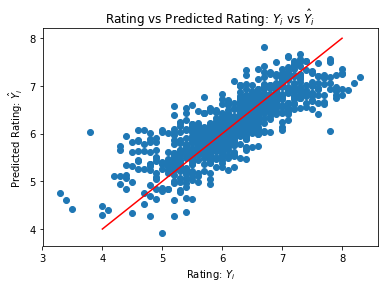

In [283]:
# Prepare the DataFrame for modeling
model_df = expand_genres[expand_genres.columns]
model_df = preprocessing(top_500_cast, top_500_dir, top_500_prod, model_df)

# Fit the model
results = fit_model(model_df)

##### Top 500 metric results
> These predicted values have an $R^2$ score of 66.17%, with a Mean Squared Error of 0.2. Compared to the [results of the top 10 metric](#results1), this is a huge improvement!

> The problem with this metric, however, is that there is no justification for using the top **_500_** actors, directors, and production companies.
<br> 500 is just too large of a number, and defeats the entire purpose of the metric, which was to find the best actors, directors, and production companies to build the model's features.

> Despite the issues with this metric, it has shown that an increase in the number of actors, directors, and production companies greatly improved the model.
<br> Lets save this knowledge for later to create a new model implementing a new metric that includes a higher number of actors, directors, and production companies with a bit more control.
<div class="alert alert-block alert-success">
Comparisons:
* [top 10](#results1)
* [new preprocessing](#results4)
* [model 2 (old preprocessing)](#results5)
* [model 3 (old preprocessing)](#results7)
* [model 4 (old preprocessing)](#results9)
* [model 5](#results12)

</div>

<a id='new_preprocessing'></a>
### Preprocessing Changes
#### Description:
> In order to increase the numerical value of each feature column, I'm going to alter the preprocessing procedure to change how the **cast**, **director**, **production_companies** feature columns are built.
<br> I will now count the total number of the top actors, directors, and production companies that are listed for each movie by genre.

#### Procedure:
> Alter the preprocessing function to count the number of top actors, directors, and production companies listed for each movie.
1. Compare performance using the top 10 metric
2. Compare performance using the top 500 metric

In [284]:
def new_preprocessing(top_cast, top_dir, top_prod, model_df):
    '''1. Build the cast, director, and production_companies feature columns'''
    # List of features
    features = ['cast', 'director', 'production_companies']
    # List of dataframes
    dataframes = [top_cast, top_dir, top_prod]
    
    # Loop through the features and their corresponding DataFrames
    for i in range(3):
        feature = features[i]
        data =  dataframes[i]
        # Split the feature column
        model_df[feature] = model_df[feature].apply(lambda x: x.split('|'))

        # Loop through the genres
        for genre in genres_list:
            try:
                # Top n of the current feature for the current genre
                top_n = data[genre]
                
                # Find all movies with a top_n feature for the current genre
                temp = model_df.loc[model_df.genres == genre, feature].apply(lambda values: sum(hit in values for hit in top_n))
                
                # Update the dataframe
                model_df.loc[model_df.genres == genre, feature] = temp
            except:
                model_df.loc[model_df.genres == genre, feature] = 0

    '''2. Build the genre feature columns'''
    # Create dummy variables for genres
    model_df[genres_list] = pd.get_dummies(model_df['genres'])
    # Drop the original 'genres' column
    model_df.drop(columns='genres', inplace=True)
    
    '''3. Collapse the DataFrame back to one movie per row'''
    # Collapse the genre features back to one movie per row
    genre_features = model_df.groupby(['original_title', 'release_date'])[genres_list].sum().reset_index()
    
    # Collapse the remaining features back to one movie per row
    agg_dict = {'cast':'sum', 'director':'sum', 'production_companies':'sum', 'vote_average':'mean', 'budget':'mean'}
    remaining_features = model_df.groupby(['original_title', 'release_date']).agg(agg_dict)
    
    # Join the features
    model_df = genre_features.join(remaining_features, on=['original_title', 'release_date'])

    '''4. Build the release_date feature column'''
    # Convert release dates to month
    model_df['release_date'] = model_df['release_date'].dt.month
    
    return model_df

<a id='results3'></a>
##### 1. Compare performance using the top 10 metric

R² (Training): 0.24792179100483147
R² (Test): 0.22042639919728424
MSE: 0.4683961591417616


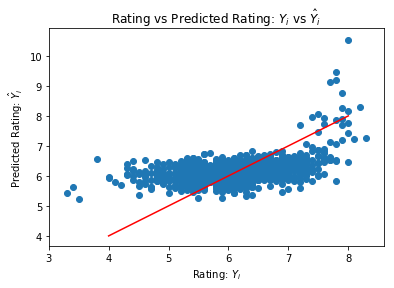

In [285]:
# Prepare the DataFrame for modeling
model_df = expand_genres[expand_genres.columns]
model_df = new_preprocessing(top_10_cast, top_10_dir, top_10_prod, model_df)

# Fit the model
results = fit_model(model_df)

##### New preprocessing using top 10 metric results
> There is little to no difference in performance for the [top 10 metric (old preprocessing)](#results1).
<div class="alert alert-block alert-success">
Comparisons:
* [old preprocessing](#results1)
* [model 2 (new preprocessing)](#results6)

</div>

<a id='results4'></a>
##### 2. Compare performance using the top 500 metric

R² (Training): 0.5751436380019682
R² (Test): 0.5657733720219272
MSE: 0.3375661245385109


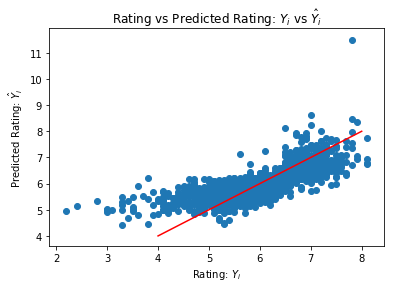

In [161]:
# Prepare the DataFrame for modeling
model_df = expand_genres[expand_genres.columns]
model_df = new_preprocessing(top_500_cast, top_500_dir, top_500_prod, model_df)

# Fit the model
results = fit_model(model_df)

##### New preprocessing using top 500 metric results
> The performance of the new preprocessing method performs slightly worse for the [top 500 metric (old preprocessing)](#results2).
<div class="alert alert-block alert-success">
Comparisons:
* [old preprocessing](#results2)
* [model 2 (new preprocessing)](#results6)
* [model 3 (new preprocessing)](#results8)
* [model 4 (new preprocessing)](#results10)

</div>

<a id='new_models'></a>
<div class="alert alert-block alert-warning">
<h1 align="center">New Models</h3> 

<a id='model2'></a>
### Model 2
#### Description:
> I will now create a new model to find the _best_ actors, directors, and production companies by genre instead of simply the top #.
* My personal definition of a "good" movie has a cut-off of 7/10; as such, I have chosen a minimum rating of 7.

> <div class="alert alert-block alert-info">
**_Purpose:_**
<br> I know that an increase in the number of actors, directors, and production companies has a positive effect on model performance. Therefore, this new metric allows me to increase the number of actors, directors, and production companies while granting me a level of control by being able to choose the minimum rating.
</div>

#### Procedure:
> Find all movies with a minimum rating of 7; find all actors, directors, and production companies by genre; then build the model.
1. Find the top actors, directors, and production companies by genre
  1. Find all movies with a minimum rating of 7
  2. Find the top actors, directors, and production companies by genre
2. Evaluate performance using the old preprocessing method
3. Evaluate performance using the new preprocessing method

##### 1. Find the top actors, directors, and production companies by genre

In [162]:
# Find all movies with a minimum rating of 7
good_movies = expand_genres.loc[expand_genres.vote_average >= 7]

# Create a new DataFrame for each attribute and expand the corresponding column
cast_genres = expand(good_movies, 'cast')
dir_genres = expand(good_movies, 'director')
prod_genres = expand(good_movies, 'production_companies')

# Find the top actors
top_cast = cast_genres.groupby('genres')['cast'].unique()
top_cast = top_cast.to_dict()

# Find the top directors
top_dir = dir_genres.groupby('genres')['director'].unique()
top_dir = top_dir.to_dict()

# Find the top production companies
top_prod = prod_genres.groupby('genres')['production_companies'].unique()
top_prod = top_prod.to_dict()

<a id='results5'></a>
##### 2. Evaluate performance using the old preprocessing method

R² (Training): 0.38213995107360754
R² (Test): 0.36116323469942857
MSE: 0.4966292649517612


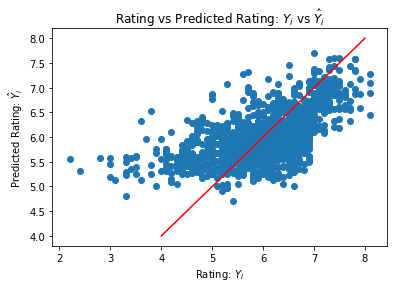

In [163]:
# Prepare the DataFrame for modeling
model_df = expand_genres[expand_genres.columns]
model_df = preprocessing(top_cast, top_dir, top_prod, model_df)

# Fit the model
results = fit_model(model_df)

##### Model 2 using old preprocessing results
> Using the old preprocessing method, this model performs better than the previous model when comparing by the [top 10 metric](#results1), but is outperformed by the [top 500 metric](#results2).
<div class="alert alert-block alert-success">
Comparisons:
* [model 1 top 500 metric (old preprocessing)](#results2)
* [model 3 (old preprocessing)](#results7)

</div>

<a id='results6'></a>
##### 3. Evaluate performance using the new preprocessing method

R² (Training): 0.4130838667066606
R² (Test): 0.374743846457378
MSE: 0.4860717491648099


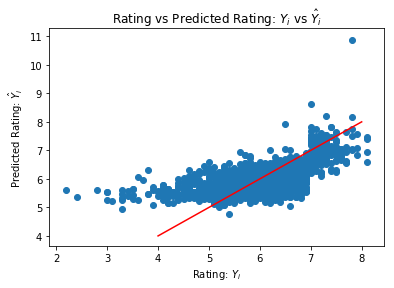

In [164]:
# Prepare the DataFrame for modeling
model_df = expand_genres[expand_genres.columns]
model_df = new_preprocessing(top_cast, top_dir, top_prod, model_df)

# Fit the model
results = fit_model(model_df)

##### Model 2 using new preprocessing results
> It is clear that compared to itself, this model performs better using the new preprocessing method. However, when compared to the previous model, it is still outperformed by the [top 500 metric](#results4).

> Regardless of which preprocessing model is used, this new model it outperformed by the top 500 metric.
<div class="alert alert-block alert-success">
Comparisons:
* [model 1 top 500 metric (new preprocessing)](#results4)
* [model 3 (new preprocessing)](#results8)

</div>

<a id='model3'></a>
### Model 3
#### Description:
> Adjust [Model 2](#model2) to round ratings to a full number, or to a half number. For example, ratings will be rounded as such:
* (5.8 - 6.2 => 6.0), (6.3 - 6.7 => 6.5), (6.8 - 7.2 => 7.0)

> <div class="alert alert-block alert-info">
**_Purpose:_**
<br> Reduce the number of possible ratings in the hopes of creating a better model.
</div>

#### Procedure:
> Round all ratings; find all actors, directors, and production companies by genre; then build the model.
1. Round all ratings
  1. Define function to round the ratings
  2. Initialize the DataFrame
  3. Use pandas .apply() method and round all ratings
2. Find the top actors, directors, and production companies by genre
  1. Find all movies with a minimum rating of 7
  2. Find the top actors, directors, and production companies by genre
3. Evaluate performance using the old preprocessing method
4. Evaluate performance using the new preprocessing method

##### 1. Round all ratings

In [165]:
# Import Decimal object
from decimal import Decimal

# Define function to round the ratings
def round_ratings(rating):
    # Find the rating's whole value
    whole_value = rating//1
    # Find the rating's decimal value
    dec_value = float(Decimal(str(rating)) % 1)
    
    # Round to whole number
    if dec_value in [0.8, 0.9, 0.0, 0.1, 0.2]:
        return round(rating)
    # Round to half number
    else:
        return whole_value + 0.5

# Initialize DataFrame
rounded_ratings = expand_genres[expand_genres.columns]

# Round ratings
rounded_ratings['vote_average'] = rounded_ratings['vote_average'].apply(round_ratings)

##### 2. Find the top actors, directors, and production companies by genre

In [166]:
# Find all movies with a minimum rating of 7
good_movies = rounded_ratings.loc[rounded_ratings.vote_average >= 7]

# Create a new DataFrame for each attribute and expand the corresponding column
cast_genres = expand(good_movies, 'cast')
dir_genres = expand(good_movies, 'director')
prod_genres = expand(good_movies, 'production_companies')

# Find the top actors
top_cast = cast_genres.groupby('genres')['cast'].unique()
top_cast = top_cast.to_dict()

# Find the top directors
top_dir = dir_genres.groupby('genres')['director'].unique()
top_dir = top_dir.to_dict()

# Find the top production companies
top_prod = prod_genres.groupby('genres')['production_companies'].unique()
top_prod = top_prod.to_dict()

<a id='results7'></a>
##### 3. Evaluate performance using the old preprocessing method

R² (Training): 0.41357378592497224
R² (Test): 0.39187086970165685
MSE: 0.4815158725338044


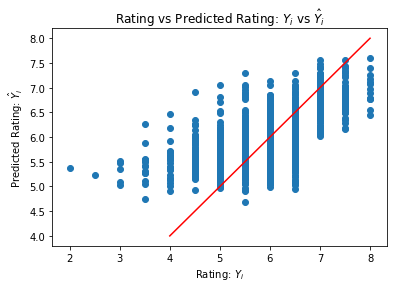

In [167]:
'''Old Preprocessing Method'''
# Prepare the DataFrame for modeling
model_df = rounded_ratings[rounded_ratings.columns]
model_df = preprocessing(top_cast, top_dir, top_prod, model_df)

# Fit the model
results = fit_model(model_df)

###### Model 3 using old preprocessing results
> Rounding the ratings actually improved the performance of the [second model using the old preprocessing method](#results5)! Unfortunately, it is still outperformed by the [first model using the top 500 metric and the old preprocessing method](#results2).
<div class="alert alert-block alert-success">
Comparisons:
* [model 1 top 500 metric (old preprocessing)](#results2)
* [model 2 (old preprocessing)](#results5)
* [model 4 (old preprocessing)](#results9)

</div>

<a id='results8'></a>
###### 4. Evaluate performance using the new preprocessing method

R² (Training): 0.45058149102760336
R² (Test): 0.41565100987929104
MSE: 0.46268678776196953


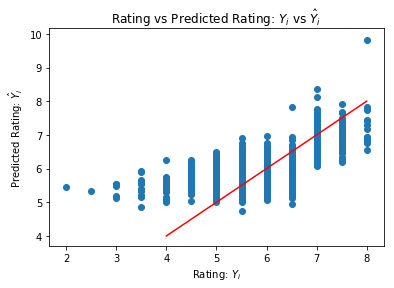

In [168]:
'''New Preprocessing Method'''
# Prepare the DataFrame for modeling
model_df = rounded_ratings[rounded_ratings.columns]
model_df = new_preprocessing(top_cast, top_dir, top_prod, model_df)

# Fit the model
results = fit_model(model_df)

###### Model 3 using new preprocessing results
> Rounding the ratings actually improved the performance of the [second model using the new preprocessing method](#results6), but is met with the same setback of being outperformed by the [first model using the top 500 metric and the new preprocessing method](#results4).
<div class="alert alert-block alert-success">
Comparisons:
* [model 1 top 500 metric (new preprocessing)](#results4)
* [model 2 (new preprocessing)](#results6)
* [model 4 (new preprocessing)](#results10)

</div>

<a id='model4'></a>
### Model 4
#### Description:
> I will adjust [Model 3](#model3) to bin the ratings for movies so that movies with a rating less than 5 will be rated as a 4, movies with a rating between 5 and 5.9 will be rated as a 5, movies with a rating between 6 and 6.9 will be rated as a 7, and so on.

> <div class="alert alert-block alert-info">
**_Purpose:_**
<br> Improve on Model 3 by further reducing the number of possible ratings.
</div>

#### Procedure:
> Bin all ratings; find all actors, directors, and production companies by genre; then build the model.
1. Bin all ratings
  1. Initialize the DataFrame
  2. Bin all ratings
2. Find the top actors, directors, and production companies by genre
  1. Find all movies with a minimum rating of 7
  2. Find the top actors, directors, and production companies by genre
3. Evaluate performance using the old preprocessing method
4. Evaluate performance using the new preprocessing method

##### 1. Bin all ratings

In [169]:
# Initialize DataFrame
bin_ratings = expand_genres[expand_genres.columns]

# Bin ratings
bin_ratings.loc[bin_ratings['vote_average'] < 5, 'vote_average'] = 4
for rating in range(5, 10):
    bin_ratings.loc[bin_ratings['vote_average'].between(rating, rating+0.9), 'vote_average'] = rating

##### 2. Find the top actors, directors, and production companies by genre

In [170]:
# Find all movies with a minimum rating of 7
good_movies = bin_ratings.loc[bin_ratings.vote_average >= 7]

# Create a new DataFrame for each attribute and expand the corresponding column
cast_genres = expand(good_movies, 'cast')
dir_genres = expand(good_movies, 'director')
prod_genres = expand(good_movies, 'production_companies')

# Find the top actors
top_cast = cast_genres.groupby('genres')['cast'].unique()
top_cast = top_cast.to_dict()

# Find the top directors
top_dir = dir_genres.groupby('genres')['director'].unique()
top_dir = top_dir.to_dict()

# Find the top production companies
top_prod = prod_genres.groupby('genres')['production_companies'].unique()
top_prod = top_prod.to_dict()

<a id='results9'></a>
###### 3. Evaluate performance using the old preprocessing method

R² (Training): 0.39110508905622643
R² (Test): 0.36492902225001445
MSE: 0.47772632343933635


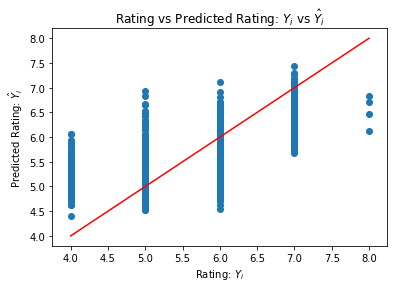

In [171]:
'''Old Preprocessing Method'''
# Prepare the DataFrame for modeling
model_df = bin_ratings[bin_ratings.columns]
model_df = preprocessing(top_cast, top_dir, top_prod, model_df)

# Fit the model
results = fit_model(model_df)

###### Model 4 using old preprocessing results
> Binning the ratings slightly decreased the performance of the [third model using the old preprocessing method](#results7), meaning that this model is also outperformed by the [first model using the top 500 metric and the old preprocessing method](#results2).
<div class="alert alert-block alert-success">
Comparisons:
* [model 1 top 500 metric (old preprocessing)](#results2)
* [model 3 (old preprocessing)](#results7)

</div>

<a id='results10'></a>
###### 4. Evaluate performance using the new preprocessing method

R² (Training): 0.4424541257019429
R² (Test): 0.3935173358867551
MSE: 0.4562210264796202


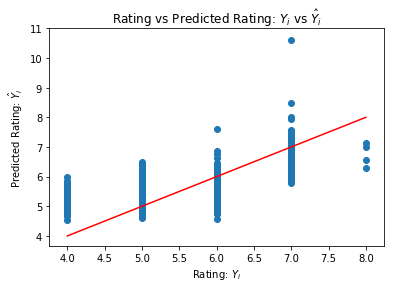

In [172]:
'''New Preprocessing Method'''
# Prepare the DataFrame for modeling
model_df = bin_ratings[bin_ratings.columns]
model_df = new_preprocessing(top_cast, top_dir, top_prod, model_df)

# Fit the model
results = fit_model(model_df)

###### Model 4 using new preprocessing results
> Once again, binning the ratings slightly decreased the performance of the [third model using the new preprocessing method](#results8), meaning that this model is also outperformed by the [first model using the top 500 metric and the new preprocessing method](#results2).
<div class="alert alert-block alert-success">
Comparisons:
* [model 1 top 500 metric (new preprocessing)](#results4)
* [model 3 (new preprocessing)](#results8)

</div>

<a id='model5'></a>
### Model 5
#### Description:
> All the models so far have been built using the [old](#preprocessing) and [new](#new_preprocessing) preprocessing procedures; both of which are very similar, and involves a list of actors, directors, and production companies for each genre to build the models' features.

> I will take this idea one step further by creating one final preprocessing procedure that takes the idea from [Model 4](#model4) to bin the ratings, in order to create a list of actors, directors, and production companies for each genre and bin combination.

> For each bin, I will create separate feature columns for the actors, directors, and production companies.
<br> This means that for n number of bins there will be n number of columns of actors, and an equivalent number of columns for directors and production companies. Because there are three features (actors, directors, and production companies), I will have n*3 total feature columns.
<br> Each column will count the number of actors, directors, and production companies listed per movie similar to before.

> This may be a bit confusing, so I'll try to explain using an example.
<br> Lets say a movie is categorized under the Action and Adventure genres, and I am using bins between 4 and 8.
<br> Because I have 5 bins, I will have 5 cast feature columns, 5 director feature columns, and 5 production_companies feature columns where each of those 5 columns corresponds to bins 4-8.
<br> If this movie has 2 actors in the Action genre under bin 5, 1 actor in the Action genre under bin 6, and 3 actors in the Adventure genre under bin 6, then its cast feature columns will look like this:
  * 4.0 cast: 0
  * 5.0 cast: 2
  * 6.0 cast: 4
  * 7.0 cast: 0
  * 8.0 cast: 0

#### Procedure:
> Build the preprocessing function; find all actors, directors, and production companies by genres and bins; then build the model.
1. Build preprocessing function
2. Find all actors, directors, and production companies by genres and bins
  1. Bin all ratings
  2. Group the top actors, directors, and production companies by genres and bins
  3. Unstack the bins, then turn to dictionary
3. Evaluate performance

##### 1. Build preprocessing function

In [173]:
def final_preprocessing(cast_bins, dir_bins, prod_bins, model_df):
    '''1. Replace the cast, director, and production_companies columns with dummy variables'''
    # List of features
    features = ['cast', 'director', 'production_companies']
    # List of dataframes
    dataframes = [cast_bins, dir_bins, prod_bins]
    # List of bins
    bins = list(cast_bins['Action'].keys())
    
    # Loop through the features and their corresponding DataFrames
    for i in range(3):
        feature = features[i]
        data =  dataframes[i]
        # Split the feature column
        model_df[feature] = model_df[feature].apply(lambda x: x.split('|'))
        
        # Loop through the genres
        for genre in genres_list:
            genre_data = data[genre]
            # Loop through the bins
            for bin_n in bins:
                # List of values for the current feature, genre, and bin
                list_n = genre_data[bin_n]
                
                if list_n is not None:
                    # Count the number of values from list_n that appear in each movie
                    temp = model_df.loc[model_df.genres == genre, feature].apply(lambda values: sum(hit in values for hit in list_n))

                    # Update the dataframe
                    model_df.loc[model_df.genres == genre, str(bin_n) + ' ' + feature] += temp
                else:
                    # Update the dataframe
                    model_df.loc[model_df.genres == genre, str(bin_n) + ' ' + feature] = 0

    '''2. Create dummy variables for each genre in the genres column'''
    # Create dummy variables for genres
    model_df[genres_list] = pd.get_dummies(model_df['genres'])
    # Drop the original 'genres' column
    model_df.drop(columns='genres', inplace=True)
    
    '''3. Collapse the DataFrame back to one movie per row'''
    # Collapse the genre features back to one movie per row
    genre_features = model_df.groupby(['original_title', 'release_date'])[genres_list].sum().reset_index()
    
    # Collapse the remaining features back to one movie per row
    agg_dict = {'vote_average':'mean', 'budget':'mean'}
    for bin_n in bins:
        agg_dict[str(bin_n)+' cast'] = 'mean'
        agg_dict[str(bin_n)+' director'] = 'mean'
        agg_dict[str(bin_n)+' production_companies'] = 'mean'
    remaining_features = model_df.groupby(['original_title', 'release_date']).agg(agg_dict)
    
    # Join the features
    model_df = genre_features.join(remaining_features, on=['original_title', 'release_date'])

    '''4. Convert the release_dates into months'''
    # Convert release dates to month
    model_df['release_date'] = model_df['release_date'].dt.month
    
    return model_df

##### 2. Find all actors, directors, and production companies by genres and bins

In [250]:
# Initialize DataFrame
bin_ratings = expand_genres[expand_genres.columns]
original_ratings = list(bin_ratings.vote_average)

# Bin ratings
bin_ratings.loc[bin_ratings['vote_average'] < 5, 'vote_average'] = 4
for rating in range(5, 10):
    bin_ratings.loc[bin_ratings['vote_average'].between(rating, rating+0.9), 'vote_average'] = rating

# Create a new DataFrame for each attribute and expand the corresponding column
cast_genres = expand(bin_ratings, 'cast')
dir_genres = expand(bin_ratings, 'director')
prod_genres = expand(bin_ratings, 'production_companies')

# Groupby genres and bins, and find the list of cast
cast_bins = cast_genres.groupby(['genres', 'vote_average'])['cast'].unique()
cast_bins = cast_bins.unstack().to_dict(orient='index')

# Groupby genres and vote_average, and find the list of directors
dir_bins = dir_genres.groupby(['genres', 'vote_average'])['director'].unique()
dir_bins = dir_bins.unstack().to_dict(orient='index')

# Groupby genres and vote_average, and find the list of production companies
prod_bins = prod_genres.groupby(['genres', 'vote_average'])['production_companies'].unique()
prod_bins = prod_bins.unstack().to_dict(orient='index')

<a id='results11'></a>
##### 3. Evaluate performance

R² (Training): 0.8629151408785175
R² (Test): 0.8423997321430676
MSE: 0.10494796012899413


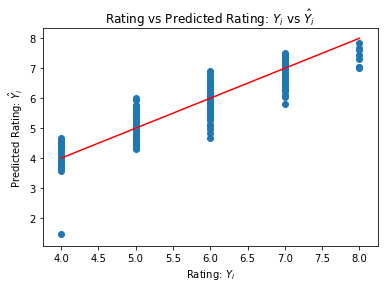

In [251]:
# Prepare the DataFrame for modeling
model_df = bin_ratings[bin_ratings.columns]

# Initialize bin columns
bins = sorted(list(model_df.vote_average.unique()))
for bin_n in bins:
    model_df[str(bin_n) + ' ' + 'cast'] = 0
    model_df[str(bin_n) + ' ' + 'director'] = 0
    model_df[str(bin_n) + ' ' + 'production_companies'] = 0
    
# Run the preprocessing procedure
model_df = final_preprocessing(cast_bins, dir_bins, prod_bins, model_df)

# Fit the model
results = fit_model(model_df)

###### Model 5 results
> This model performs extremely well!
<br> With an $R_2$ of 84.2%, it is the first model to exceed the performance of the [first model using the top 500 metric and the old preprocessing method](#results2).

> The one downfall, is that it falls short for movies with a rating of 8.0. The reason seems to be associated with the sparse amount of data for movies of that rating. I'm confident that if the dataset was updated to provide movies with a uniform amount of ratings, this model would perform even better.

> With this model, I have finally created a model with great performance and explainable features, unlike the first model.

> Although this model is great as is, it may perform even better as a classifier. Lets try to convert it into one.
<div class="alert alert-block alert-success">
Comparisons:
* [model 1 top 500 metric (old preprocessing)](#results2)
* [clf](#results12)

</div>

<a id='classification'></a>
<div class="alert alert-block alert-warning">
<h1 align="center">Classification</h3> 

<a id='fit_clf'></a>
### Fitting the Classifier
#### Description:
> I will build a function to fit the data to a classifier using SVC (Support Vector Classification).
<br> This will not be able to predict a movie's rating using a continuous range, instead, it will classify movies into groups.


#### Procedure:
> Using the **cast**, **director**, **production_companies**, **release_date**, **budget**, and the **genres** columns as the features and the **vote_average** column as the target, split the data into training and test sets. Fit the model to the training set, and use the fitted model to predict the average rating.
1. Split the data into training and test sets
  1. Split the DataFrame into two variables, X for the features, and y for the target
  2. Use the train_test_split function to split the data into a training set, and a test set
  3. Standardize the features of the training and test sets
2. Fit the model to the training set using the SVC class from sklearn.svm
3. Plot the ratings vs their predictions

In [214]:
def fit_clf(model_df):
    '''1. Split the data into training and test sets'''
    # Variable to hold feature data
    X = model_df.drop(columns=['original_title', 'vote_average'])
    
    # Variable to hold target data
    y = model_df['vote_average']
    
    # Split the data into training and test sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)
    
    # Standardize the features
    temp = StandardScaler().fit(X_train)
    X_train = temp.transform(X_train)
    X_test = temp.transform(X_test)
    
    '''2. Fit the model to the training set'''
    model = SVC(kernel='linear')
    results = model.fit(X_train, y_train)
    
    '''3. Evaluate model performance'''
    # Results using sklearn
    y_pred = results.predict(X_test)
    
    # Print the accuracy
    print('Accuracy (Training): {}'.format(results.score(X_train, y_train)))
    print('Accuracy (Test): {}'.format(results.score(X_test, y_test)))
    
    # Plot the Rating vs. Predicted Rating
    temp = pd.DataFrame({'$Y_i$':y_test.values.astype(float), '$\hat{Y}_i$':y_pred.astype(float)})
    sns.swarmplot(x='$Y_i$', y='$\hat{Y}_i$', data=temp)
    plt.title("Rating vs Predicted Rating: $Y_i$ vs $\hat{Y}_i$");
    
    return results

<a id='clf'></a>
### CLF
#### Description:
> Using the [fit_clf()](#fit_clf) function I have written above, I will not turn [Model 5](#model5) into a classifier.

> <div class="alert alert-block alert-info">
**_Purpose:_**
<br> Because Model 5 has binned ratings, it may perform better as a classifier. Instead of making predictions within a linear range, the model will make strict predictions using the rounded ratings as classes.
</div>

#### Procedure:
> Follow the same procedure as [Model 5](#model3), using the [fit_clf()](#fit_clf) function to build a classifier.
1. Find all actors, directors, and production companies by genres and bins
  1. Bin all ratings
  2. Group the top actors, directors, and production companies by genres and bins
  3. Unstack the bins, then turn to dictionary
2. Evaluate performance

##### 1. Find all actors, directors, and production companies by genres and bins

In [248]:
# Initialize DataFrame
bin_ratings = expand_genres[expand_genres.columns]

# Bin ratings
bin_ratings.loc[bin_ratings['vote_average'] < 5, 'vote_average'] = 4
for rating in range(5, 10):
    bin_ratings.loc[bin_ratings['vote_average'].between(rating, rating+0.9), 'vote_average'] = rating

# Create a new DataFrame for each attribute and expand the corresponding column
cast_genres = expand(bin_ratings, 'cast')
dir_genres = expand(bin_ratings, 'director')
prod_genres = expand(bin_ratings, 'production_companies')

# Groupby genres and bins, and find the list of cast
cast_bins = cast_genres.groupby(['genres', 'vote_average'])['cast'].unique()
cast_bins = cast_bins.unstack().to_dict(orient='index')

# Groupby genres and vote_average, and find the list of directors
dir_bins = dir_genres.groupby(['genres', 'vote_average'])['director'].unique()
dir_bins = dir_bins.unstack().to_dict(orient='index')

# Groupby genres and vote_average, and find the list of production companies
prod_bins = prod_genres.groupby(['genres', 'vote_average'])['production_companies'].unique()
prod_bins = prod_bins.unstack().to_dict(orient='index')

<a id='results12'></a>
##### 2. Evaluate performance

Accuracy (Training): 0.9996494917630564
Accuracy (Test): 0.9936974789915967


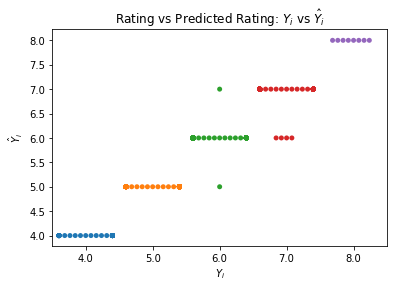

In [249]:
# Prepare the DataFrame for modeling
model_df = bin_ratings[bin_ratings.columns]

# Initialize bin columns
bins = sorted(list(model_df.vote_average.unique()))
for bin_n in bins:
    model_df[str(bin_n) + ' ' + 'cast'] = 0
    model_df[str(bin_n) + ' ' + 'director'] = 0
    model_df[str(bin_n) + ' ' + 'production_companies'] = 0

# Run the preprocessing procedure
model_df = final_preprocessing(cast_bins, dir_bins, prod_bins, model_df)
model_df['vote_average'] = model_df['vote_average'].astype(str)

# Fit the model
results = fit_clf(model_df)

###### Model 5 results
> This classifier, as expected, improves the performance of the [Model 5](#results11), with a shockingly high accuracy score of 99.4%!

> The classifier can now properly classify movies with a rating of 8.
<br> The regression model on the other hand, incorrectly predicted all such movies, but managed to get relatively close.

> Its hard to say with certainty, if the model is better as a classifier or as a regression model.
<br> On one hand, the classifier is capable of classifying nearly all movies correctly, but is unable to predict a movie's rating numerically.
<br> On the other hand, the regression model is far less accurate with each rating fluctating between an error of (+/-)1.0 on average, but it offers more flexibility since its predictions follow a linear range.
<div class="alert alert-block alert-success">
Comparisons:
* [model 5](#results11)

</div>

<a id='conclusions'></a>
## Conclusions

In conclusion, I have built two models that can predict a movie's rating within reasonable accuracy, thus achieving my goal. These two models use the exact same features to learn from, but the difference is that one is a linear regression model while the other is a classifier. The linear regression model is far less accurate, with an $R^2$ score of 84.2%, while the classifier has an accuracy score of 99.4%. They are both good models, but have different uses. The linear regression model will be good for predicting a rating within a continuous range if you are less concerned with accuracy. The classifier, on the other hand, is only capable of creating discrete predictions which is great for predicting ratings using a grading scale, offering a high level of accuracy for general grades. 

To reach my goal, I have built several models. In total, I have built 5 linear regression models and 1 classifier model. The first regression model was the base for the next 4 models, in which each succeeding model is built upon the model that preceded it. The classification model was adapted from the fifth linear regression model and was built using the same features, with the only difference being that it was turned from a regression model into a classification model. The fifth linear regression model and the classifier, respectively, are the two final models that I mentioned in the previous paragraph.

With these two models, a client working in the movie industry will be able to test different combinations of actors, directors, and production companies with varying budgets to create a highly rated movie. A production company will typically offer a specified budget that the client can use to calculate the cost of production, and determine which actors and directors will be feasible. The client can then hold auditions and decide which actors they like the most, but it may be hard to choose which actors will play their respective roles the best. To remedy this problem, my models will be able to present insight on the combinations of actors and directors by using the predicted ratings. This is just one specific problem that my project can resolve, thus demonstrating its utility. 

There are many aspects that come into play when trying to produce a great movie. My project does not offer a solution to every single problem, but it does a tremendous job of predicting movie ratings using a combination of actors, directors, production companies, genres, and budget. With this knowledge, clients will have greater confidence in producing their best movies..